In [1]:
from keras.models import model_from_json
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

Using TensorFlow backend.


# Load Model

In [2]:
MODEL_DIR = "./s1p10_logs/[bottom_half]2019_06_04_20_34/"
MODEL_NAME = "bottom_half_s1p10_model_2019_06_04_20_34"
# load json and create model
with open(MODEL_DIR + "%s.json" % MODEL_NAME, 'r') as json_file:
    loaded_model_json = json_file.read()

model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights(MODEL_DIR + "%s.h5" % MODEL_NAME)
print("Loaded model from disk")

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_in (InputLayer)           (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
resnet8 (Model)                 (None, 6272)         309088      image_in[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 6272)         0           resnet8[1][0]

In [3]:
IMAGE_SHAPE = (200, 200, 1)
NUM_LABELS = 5
BINS_EDGE = np.load("./s1p10_data/s1p10_bins_edge.npy")
NUM_CLASSES = len(BINS_EDGE) - 1  

# Load Validation Dataset & Get Model Prediction

In [4]:
# X_val, y_val = gen_classifier_dataset("./s1p10_data/s1p10_CH2_002_output_validation.csv", **gen_param)
X_val = np.load('./s1p10_data/bottom_half_CH2_validation_X.npy')
y_val_arr = np.load('./s1p10_data/bottom_half_CH2_validation_y.npy')
y_val = [y_val_arr[i, :, :]for i in range(NUM_LABELS)]

In [5]:
X_val.shape

(2026, 200, 200, 1)

In [6]:
y_val[0].shape

(2026, 114)

In [7]:
# Get model prediction
y_hat = model.predict(X_val, verbose=1)

2026/2026 [==============================] - 3s 1ms/step


In [8]:
y_hat[0].shape

(2026, 114)

# 2. Model Performance
## 2.1 Metrics 
Two metrics are used to access model peformance
* **Root Mean Square Error**
* **Exaplained Variance Score**

In [9]:
def one_hot_to_angle(one_hot_arr):
    """
    Decode 1 one hot encoded vector to get angle
    
    Input:
        one_hot_arr (np.ndarray): shape (1, NUM_CLASSES)
        bins_edge (np.ndarray): shape (1, NUM_CLASSES + 1)
    """
    angle_id = np.argmax(one_hot_arr)
    if angle_id < NUM_CLASSES:
        return (BINS_EDGE[angle_id] + BINS_EDGE[angle_id + 1]) / 2.
    else:
        return BINS_EDGE[angle_id]

def id_to_angle(one_hot_arr):
    """
    Decode a matrix of one_hot vector (each vector is a row)
    """
    angels = np.zeros(one_hot_arr.shape[0])
    for i in range(len(angels)):
        angels[i] = one_hot_to_angle(one_hot_arr[i, :])
    return angels

In [10]:
def root_mean_squared_error(y, y_hat):
    return np.sqrt(np.mean(np.square(y_hat - y)))

In [11]:
rmse_seq = []
eva_seq = []
for i in range(NUM_LABELS):
    # Get first angle ID in the sequence
    y_id = y_val[i]
    y_hat_id = y_hat[i]

    # Convert angle ID to angle value
    y_value = id_to_angle(y_id)
    y_hat_value = id_to_angle(y_hat_id)
    
    # calculate RMSE
    rmse_seq.append(root_mean_squared_error(y_value, y_hat_value))
    eva_seq.append(explained_variance_score(y_value, y_hat_value))

### Baseline from DroNet paper:
**RMSE: 0.109**

**EVA: 0.737**

In [12]:
print("\t\t RMSE \t\t EVA")
for i in range(NUM_LABELS):
    print("Pred %d: \t %.4f \t %.4f" % (i, rmse_seq[i], eva_seq[i]))

		 RMSE 		 EVA
Pred 0: 	 0.1341 	 0.7821
Pred 1: 	 0.1450 	 0.7467
Pred 2: 	 0.1106 	 0.8487
Pred 3: 	 0.1096 	 0.8498
Pred 4: 	 0.1119 	 0.8403


## 2.2 Angle ID distribution

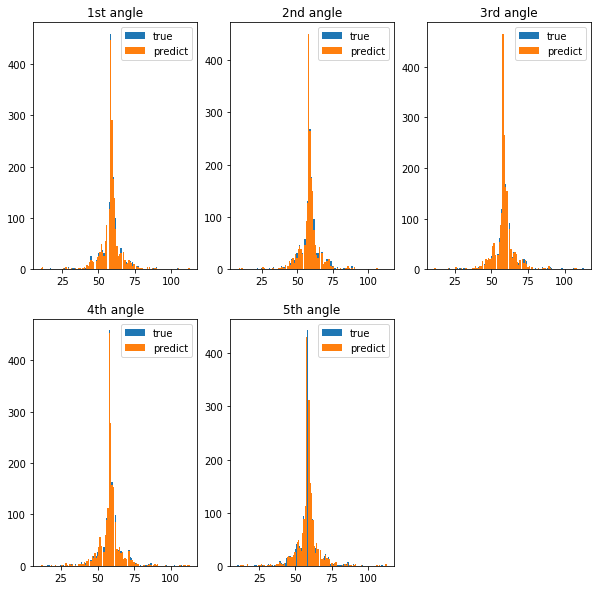

In [13]:
# convert y_val to ID
y_val_id_list = [np.argmax(y_val[j], axis=1) for j in range(NUM_LABELS)]
y_hat_id_list = [np.argmax(y_hat[j], axis=1) for j in range(NUM_LABELS)]

# Plot angel ID histogram for each prediciton in the sequence
plt.figure(figsize=(10, 10))
plt.subplot(231)
plt.hist(y_val_id_list[0], bins=NUM_CLASSES, label="true")
plt.hist(y_hat_id_list[0], bins=NUM_CLASSES, label="predict")
plt.title("1st angle")
plt.legend(loc='upper right')

plt.subplot(232)
plt.hist(y_val_id_list[1], bins=NUM_CLASSES, label="true")
plt.hist(y_hat_id_list[1], bins=NUM_CLASSES, label="predict")
plt.title("2nd angle")
plt.legend(loc='upper right')

plt.subplot(233)
plt.hist(y_val_id_list[2], bins=NUM_CLASSES, label="true")
plt.hist(y_hat_id_list[2], bins=NUM_CLASSES, label="predict")
plt.title("3rd angle")
plt.legend(loc='upper right')

plt.subplot(234)
plt.hist(y_val_id_list[3], bins=NUM_CLASSES, label="true")
plt.hist(y_hat_id_list[3], bins=NUM_CLASSES, label="predict")
plt.title("4th angle")
plt.legend(loc='upper right')

plt.subplot(235)
plt.hist(y_val_id_list[4], bins=NUM_CLASSES, label="true")
plt.hist(y_hat_id_list[4], bins=NUM_CLASSES, label="predict")
plt.title("5th angle")
plt.legend(loc='upper right')


plt.show()